In [1]:
%matplotlib widget
import matplotlib.pyplot as plt


In [2]:
# get the images for the spair Train train datasets
import glob
import os 
img_dir = "/home/tlips/Code/few-shot-keypoints/data/SPair-71k/JPEGImages/bicycle"

images = glob.glob(os.path.join(img_dir, "*.jpg"))

print(len(images))

100


In [3]:
# create featurizer 



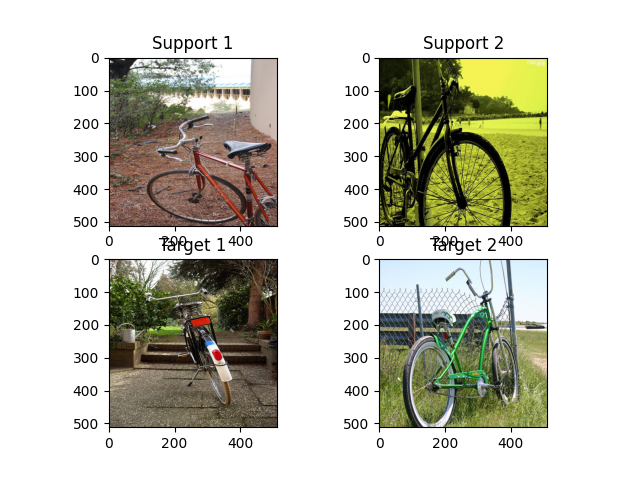

In [4]:
from PIL import Image
support_image_1 = images[0]
support_image_2 = images[1]

target_image_1 = images[2]
target_image_2 = images[3]

# load the images

support_image_1 = Image.open(support_image_1)
support_image_2 = Image.open(support_image_2)
target_image_1 = Image.open(target_image_1)
target_image_2 = Image.open(target_image_2)

# resize to 512x512
support_image_1 = support_image_1.resize((512, 512))
support_image_2 = support_image_2.resize((512, 512))
target_image_1 = target_image_1.resize((512, 512))
target_image_2 = target_image_2.resize((512, 512))

# display the images
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(support_image_1)
ax[0, 0].set_title('Support 1')
ax[0, 1].imshow(support_image_2)
ax[0, 1].set_title('Support 2')
ax[1, 0].imshow(target_image_1)
ax[1, 0].set_title('Target 1')
ax[1, 1].imshow(target_image_2)
ax[1, 1].set_title('Target 2')
plt.show()

In [5]:
# Make sure you have the necessary libraries installed
# pip install matplotlib numpy Pillow

import numpy as np
from PIL import Image



# --- Your Code Starts Here ---

# List to store the coordinates
img_coords = []

# Define the function that will be called on a mouse click
def click_callback(img_coords, ax, fig):
    def onclick(event):
        """
        This function is called when you click on the image.
        It appends the (x, y) coordinates to the 'coords' list.
        """
        # event.xdata and event.ydata are the floating point coordinates of the click
        if event.xdata is not None and event.ydata is not None:
            ix, iy = int(event.xdata), int(event.ydata)
            print(f'Clicked at x={ix}, y={iy}')
            if len(img_coords) == 0:
                img_coords.append((ix, iy))
                ax.scatter(ix, iy, c='red', s=50)
                fig.canvas.draw()
            else:
                print("Already clicked on a point")
    return onclick





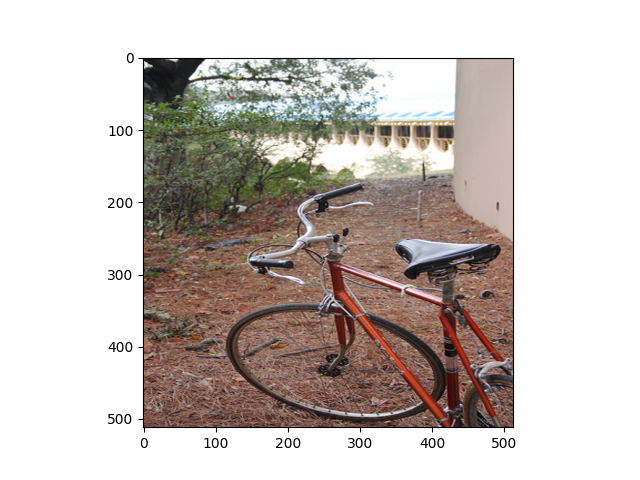

In [6]:
# get coords in support image 1

# Load your image
# Replace 'your_image.png' with the actual path to your image file

img_coords_1 = []
img = np.array(support_image_1)


# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Connect the 'button_press_event' to the 'onclick' function
cid = fig.canvas.mpl_connect('button_press_event', click_callback(img_coords_1, ax, fig))

# Show the plot
plt.show()

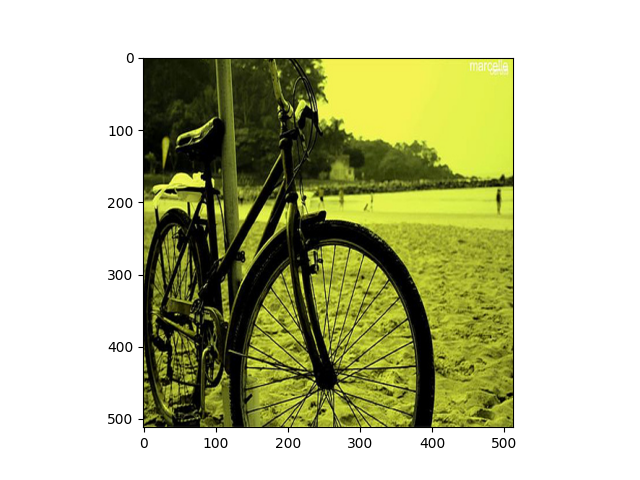

In [7]:
# get coords in support image 1

# Load your image
# Replace 'your_image.png' with the actual path to your image file

img_coords_2 = []
img = np.array(support_image_2)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Connect the 'button_press_event' to the 'onclick' function
cid = fig.canvas.mpl_connect('button_press_event', click_callback(img_coords_2, ax, fig))

# Show the plot
plt.show()

In [8]:
from few_shot_keypoints.featurizers import FeaturizerRegistry

featurizer = FeaturizerRegistry.create('dinov2-s')

In [9]:
# get feature maps of all images

from torchvision import transforms
to_tensor = transforms.ToTensor()
def get_feature_maps(img, featurizer):
    tmp_img = img.copy()
    tmp_img = to_tensor(tmp_img)
    tmp_img = tmp_img.unsqueeze(0)
    return featurizer.extract_features(tmp_img).squeeze(0)



support_1_feature_maps = get_feature_maps(support_image_1, featurizer)
support_2_feature_maps = get_feature_maps(support_image_2, featurizer)

target_1_feature_maps = get_feature_maps(target_image_1, featurizer)
target_2_feature_maps = get_feature_maps(target_image_2, featurizer)



In [11]:
print(img_coords_1)
u1,v1 = img_coords_1[0]
u2,v2 = img_coords_2[0]
print(img_coords_2)
support_1_vector = support_1_feature_maps[:, v1, u1]
support_2_vector = support_2_feature_maps[:, v2, u2]

import torch
# get cosine similarity

target_1_support_1_similarity = torch.nn.functional.cosine_similarity(target_1_feature_maps, support_1_vector.unsqueeze(1).unsqueeze(2), dim=0)
target_1_support_2_similarity = torch.nn.functional.cosine_similarity(target_1_feature_maps, support_2_vector.unsqueeze(1).unsqueeze(2), dim=0)
target_2_support_1_similarity = torch.nn.functional.cosine_similarity(target_2_feature_maps, support_1_vector.unsqueeze(1).unsqueeze(2), dim=0)
target_2_support_2_similarity = torch.nn.functional.cosine_similarity(target_2_feature_maps, support_2_vector.unsqueeze(1).unsqueeze(2), dim=0)

# get the best match

target1_support1_best_match = torch.argmax(target_1_support_1_similarity)
target1_support2_best_match = torch.argmax(target_1_support_2_similarity)
target2_support1_best_match = torch.argmax(target_2_support_1_similarity)
target2_support2_best_match = torch.argmax(target_2_support_2_similarity)

target1_support1_best_match_v, target1_support1_best_match_u = torch.unravel_index(target1_support1_best_match, target_1_support_1_similarity.shape)
target1_support2_best_match_v, target1_support2_best_match_u = torch.unravel_index(target1_support2_best_match, target_1_support_2_similarity.shape)
target2_support1_best_match_v, target2_support1_best_match_u = torch.unravel_index(target2_support1_best_match, target_2_support_1_similarity.shape)
target2_support2_best_match_v, target2_support2_best_match_u = torch.unravel_index(target2_support2_best_match, target_2_support_2_similarity.shape)





[(220, 256)]
[(198, 76)]


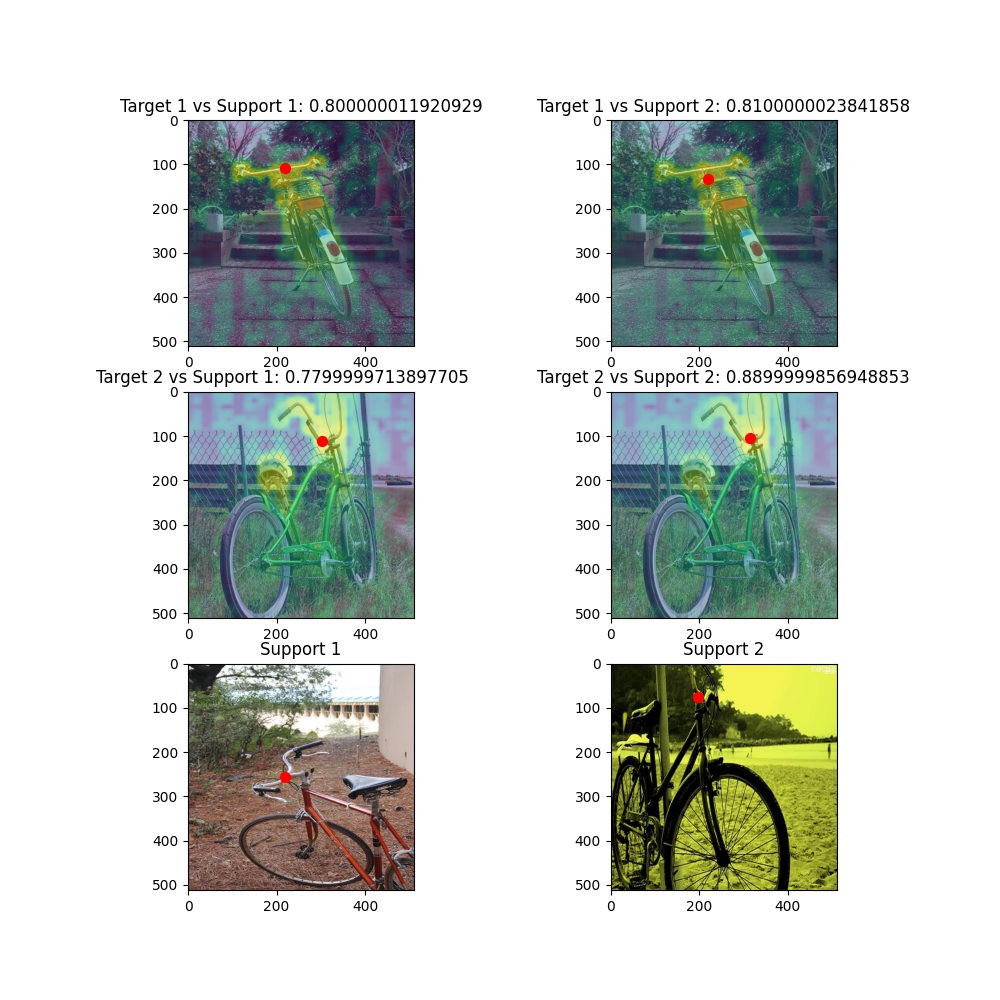

In [12]:
# visualize heatmap of cosine similarity and best match for each support and each target image in a 2x2 grid
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with 2x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot each heatmap in a subplot with overlaid images
axs[0, 0].imshow(target_image_1)
axs[0, 0].imshow(target_1_support_1_similarity.cpu().numpy(), cmap='viridis', alpha=0.5)
axs[0, 0].scatter(target1_support1_best_match_u.cpu().numpy(), target1_support1_best_match_v.cpu().numpy(), c='red', s=50)
#display similarity score
axs[0, 0].set_title(f'Target 1 vs Support 1: {target_1_support_1_similarity[target1_support2_best_match_v, target1_support2_best_match_u].cpu().numpy().round(2)}')

axs[0, 1].imshow(target_image_1)
axs[0, 1].imshow(target_1_support_2_similarity.cpu().numpy(), cmap='viridis', alpha=0.5)
axs[0, 1].scatter(target1_support2_best_match_u.cpu().numpy(), target1_support2_best_match_v.cpu().numpy(), c='red', s=50)
axs[0, 1].set_title(f'Target 1 vs Support 2: {target_1_support_2_similarity[target1_support2_best_match_v, target1_support2_best_match_u].cpu().numpy().round(2)}')

axs[1, 0].imshow(target_image_2)
axs[1, 0].imshow(target_2_support_1_similarity.cpu().numpy(), cmap='viridis', alpha=0.5)
axs[1, 0].scatter(target2_support1_best_match_u.cpu().numpy(), target2_support1_best_match_v.cpu().numpy(), c='red', s=50)
axs[1, 0].set_title(f'Target 2 vs Support 1: {target_2_support_1_similarity[target2_support1_best_match_v, target2_support1_best_match_u].cpu().numpy().round(2)}       ')

axs[1, 1].imshow(target_image_2)
axs[1, 1].imshow(target_2_support_2_similarity.cpu().numpy(), cmap='viridis', alpha=0.5)
axs[1, 1].scatter(target2_support2_best_match_u.cpu().numpy(), target2_support2_best_match_v.cpu().numpy(), c='red', s=50)
axs[1, 1].set_title(f'Target 2 vs Support 2: {target_2_support_2_similarity[target2_support2_best_match_v, target2_support2_best_match_u].cpu().numpy().round(2)}')

# show support images and keypoint
axs[2, 0].imshow(support_image_1)
axs[2, 0].scatter(u1, v1 , c='red', s=50)
axs[2, 0].set_title('Support 1')

axs[2, 1].imshow(support_image_2)
axs[2, 1].scatter(u2, v2, c='red', s=50)
axs[2, 1].set_title('Support 2')

plt.show()